# <center>Gesture Recognition</center>

Note : You might find two errors in the output.
1. KeyboardInterrupt: I stopped the model in between
2. GraphExecutionError: Google Colab Disconnected

In [ ]:
##Connect Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

#### Libraries

In [ ]:
## Imports
import numpy as np
import pandas as pd
import re
import os
import imageio.v2 as imageio
import datetime
from skimage.transform import resize
import cv2
import random
import matplotlib.pyplot as plt


## Modelling packages
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

## Set Random seeds so results don't vary much
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

#### Data

In [ ]:
column_names = ['Folder Name', 'Gesture', 'Class']
train_csv = pd.read_csv('/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train.csv', sep=';', header = None, names = column_names)
val_csv = pd.read_csv('/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val.csv', sep=';', header = None, names = column_names)

# Data manipulation
train_csv['Gesture'] = train_csv['Gesture'].str.replace('_', ' ').str.rstrip('_new')
train_csv['Gesture'] = train_csv['Gesture'].str.replace('Left Swipe new Left Swipe', 'Left Swipe')
train_csv['Gesture'] = train_csv['Gesture'].str.replace('Stop Gesture', 'Stop')


In [ ]:
# Display
train_csv.head(10)

,Folder Name,Gesture,Class
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left Swipe,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left Swipe,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left Swipe,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left Swipe,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left Swipe,0
5,WIN_20180925_17_21_28_Pro_Left_Swipe_new,Left Swipe,0
6,WIN_20180925_17_22_55_Pro_Left_Swipe_new,Left Swipe,0
7,WIN_20180925_17_24_49_Pro_Left_Swipe_new,Left Swipe,0
8,WIN_20180925_17_26_25_Pro_Left_Swipe_new,Left Swipe,0
9,WIN_20180925_17_26_51_Pro_Left_Swipe_new,Left Swipe,0


In [ ]:
train_csv.shape

(663, 3)

### Visualization

In [ ]:
# Value Count of Gestures
train_csv['Gesture'].value_counts()

Right Swipe     137
Thumbs Down     137
Left Swipe      136
Stop            130
Thumbs Up       123
Name: Gesture, dtype: int64

In [ ]:
# Value Count of Gesture Classes
train_csv['Class'].value_counts().sort_index()

0    136
1    137
2    130
3    137
4    123
Name: Class, dtype: int64

We can see there is no class imbalance, so we can continue.

Dispaly random image from each class

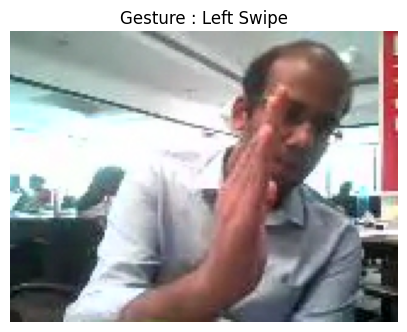

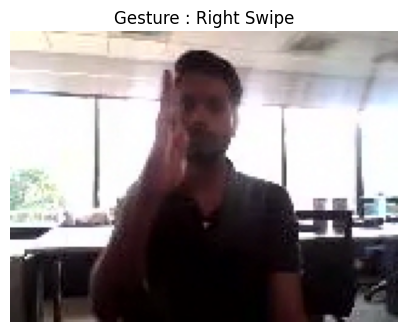

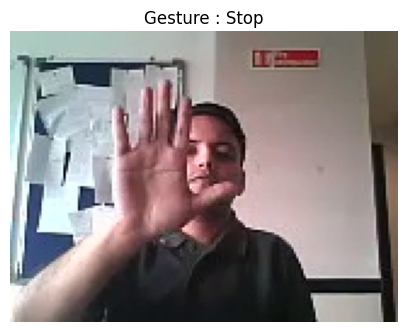

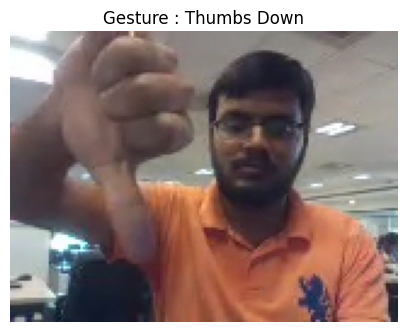

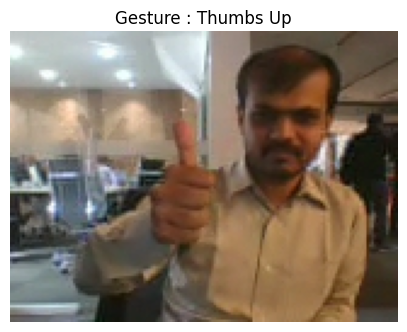

In [ ]:
# Folder containing the subfolders with images
train_folder = '/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train/'

# Group the DataFrame by gesture class
grouped = train_csv.groupby('Class')

# Iterate through each gesture class and display a random image
for gesture_class, group_df in grouped:
    random_row = group_df.sample(n=1).iloc[0]
    folder_name = random_row['Folder Name']

    extracted_string = re.search(r'Pro_(.*?)_new', folder_name).group(1)
    extracted_string = extracted_string.replace('_', ' ')

    # Construct the path to the folder
    folder_path = os.path.join(train_folder, folder_name)
    image_files = os.listdir(folder_path)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(folder_path, random_image_file)

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f'Gesture : {extracted_string}')
    plt.axis('off')
    plt.show()


* I displayed image multiple times and found that, both left and right swipe images are swiping towards left.
* So in the generator function i will be flipping the Right_Swipe images by 180 Degrees, so that the Right Swipe gesture is recognized correctly

## Data Prepration

### Functions

##### Generator Function
> This function creates batches of images that will be feeded into the model training

In [ ]:
### Custom Generator function

#''''
## Arguments passed:
# source_path = Path to Source
# folder_list = Path to folder containing all sequences
# batch_size = batch size
# num_sequences = Number of sequences in the folder
# img_idx = number of images to be taken from sequences folder
# (had to define img_idx outside function as it is also required in calculation input_shape for the model)
# res = Image Resolution
#''''
def generator(source_path, folder_list, batch_size, num_sequences, img_idx, res):
    print( 'Source path = ', source_path, '; Resolution =', res, '; batch size =', batch_size)
    img_idx = img_idx
    while True:
        t = np.random.permutation(folder_list)
        num_batches = num_sequences//batch_size # calculate the number of batches
        remaining_batch = num_sequences % batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), res[0], res[1], 3))
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # Check if the image is right swipe, if yes, flip the image by 180 Degrees
                    if 'Right' in image_path and 'Swipe' in image_path:
                        image = np.rot90(image, 2)  # Flip image by 180 degrees

                    # Crop image to 1:1 ratio (portrait or landscape)
                    width, height, _ = image.shape
                    size = min(width, height)
                    left = (width - size) // 2
                    top = (height - size) // 2
                    right = left + size
                    bottom = top + size
                    # Crop according to the aspect ratio
                    if width > height:
                        image = image[:, left:right]   # if landscape crop left & right
                    elif height > width:
                        image = image[top:bottom, :]   # if portrait crop top and bottom

                    ## Resize image
                    resized_image = resize(image, res)

                    ## Normalize image
                    normalized_image = resized_image / 255.0

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = normalized_image[:, :, 0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalized_image[:, :, 1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalized_image[:, :, 2]#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        if remaining_batch > 0:
            batch_data = np.zeros((remaining_batch, len(img_idx), res[0], res[1], 3))
            batch_labels = np.zeros((remaining_batch, 5))
            for batch in range(remaining_batch):  # Introduce batch variable in remaining_batches loop
              folder = num_batches * batch_size + batch  # Calculate the correct folder index
              imgs = os.listdir(source_path + '/' + t[folder].split(';')[0])
              for idx, item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                     # Check if the image is right swipe, if yes, flip the image by 180 Degrees
                    if 'Right' in image_path and 'Swipe' in image_path:
                        image = np.rot90(image, 2)  # Flip image by 180 degrees

                    # Crop image to 1:1 ratio (portrait or landscape)
                    width, height, _ = image.shape
                    size = min(width, height)
                    left = (width - size) // 2
                    top = (height - size) // 2
                    right = left + size
                    bottom = top + size
                    # Crop according to the aspect ratio
                    if width > height:
                        image = image[:, left:right]   # if landscape crop left & right
                    elif height > width:
                        image = image[top:bottom, :]   # if portrait crop top and bottom


                    ## Resize image
                    resized_image = resize(image, res)

                    ## Normalize image
                    normalized_image = resized_image / 255.0
                    batch_data[batch,idx,:,:,0] = normalized_image[:, :, 0]
                    batch_data[batch,idx,:,:,1] = normalized_image[:, :, 1]
                    batch_data[batch,idx,:,:,2] = normalized_image[:, :, 2]
                    # print('Processed remaining batch images')

              # batch_labels[folder - (num_batches * batch_size), int(t[folder].split(';')[2])] = 1
              batch_labels[batch, int(t[folder].split(';')[2])] = 1

            yield batch_data, batch_labels# write the code for the remaining data points which are left after full batches


##### Callback Function
> This function create a list of callbacks for the model

In [ ]:
def callbacks(init_name):
  ## Save model on every epoch
  curr_dt_time = datetime.datetime.now()
  model_directory = '/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/'
  model_name = init_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
  if not os.path.exists(model_name):
      os.mkdir(model_name)
  filepath = model_directory + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
  ## Reduce learning rate if accuracy stops increasing
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
  early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

  return [checkpoint, LR, early_stopping]

##### Steps Function
> Calculates steps to be taken per epoch and Validation steps

In [ ]:
def epoch_valsteps(num_train_sequences, num_val_sequences, batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  return steps_per_epoch, validation_steps

##### Path test function
> Tests whether the given path exists or not

In [ ]:
def path_test(train_path, val_path):
  # Check if the train directory exists
  if os.path.exists(train_path):
      print("train directory exists.")
  else:
      print("train directory does not exist.")

  # Check if the val directory exists
  if os.path.exists(val_path):
      print("val directory exists.")
  else:
      print("val directory does not exist.")

##### Parameter Function
> <p>This function takes in the parameters to be changed in the model, like: Epochs, images resolution to be kept, batch size etc
> <p>And return the required values for model training, like: Callback list, Training genrator, Validation Generator etc.

In [ ]:
def model_params(idx = (0, 15), batch_size = 100, train_seq = 0, val_seq = 0, init_name = 'nn_model', epochs = 30, res = (100, 100)):
  """
  Parameters:
  idx (int, optional) : No of image indices to pick from folder, default = 15
  batch_size (int, optional) : Batch Size, default = 100
  train_seq (int, optional) : Number of train sequences, default = 663
  val_seq (int, optional) : Number of validation sequences, default = 100
  init_name (int, optional) : Initial name of model, default = 'nn_model'
  epochs : Number of Epochs
  res : Resolution for image

  Return:
  callback_list : List of [checkpoint, LR]
  steps_per_epoch : Steps per epoch
  validation_steps : No. of validation steps
  train_generator : Train Generator
  val_generator : Validation Generator
  """

  # Path
  train_doc = np.random.permutation(open('/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train.csv').readlines())
  val_doc = np.random.permutation(open('/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val.csv').readlines())
  train_path = '/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train'
  val_path = '/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val'
  # path_test(train_path, val_path)

  ## Parameters
  # Image Index
  img_idx = []
  for i in range(idx[0], idx[1]):
    img_idx.append(i)

  # Batch Size
  batch_size = batch_size

  # Train & Val Sequences
  if train_seq == 0:
    num_train_sequences = len(train_doc)
  else:
    num_train_sequences = train_seq
  if val_seq == 0:
    num_val_sequences = len(val_doc)
  else:
    num_val_sequences = val_seq

  # Input Shape
  input_shape = (len(img_idx), res[0], res[1], 3)

  print('No. of images : ', len(img_idx))
  print('Batch Size : ', batch_size)
  print('Total Train sequences : ', num_train_sequences)
  print('Total Validation sequences : ', num_val_sequences)
  print('Epochs : ', epochs)
  print('Resolution : ', res)

  # Calling Functions to get values
  callbacks_list = callbacks(init_name)
  steps_per_epoch, validation_steps = epoch_valsteps(num_train_sequences, num_val_sequences, batch_size)
  train_generator = generator(train_path, train_doc, batch_size, num_train_sequences, img_idx, res)
  val_generator = generator(val_path, val_doc, batch_size, num_val_sequences, img_idx, res)

  return callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape

In [ ]:
lr = 0.001                  # Learning Rate
num_classes = 5             # Number Classes

In [ ]:
# List of parameter we can change, just call params
params = 'img_idx,\nbatch_size,\nnum_train_sequences,\nnum_val_sequences,\nlr,\nepochs,\nres'
print(params)

img_idx,
batch_size,
num_train_sequences,
num_val_sequences,
lr,
epochs,
res


# Models

## 1. Conv3D Models

### Model 1
Conv3D + Batch Normalization

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(0, 20),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_3d_BN',
  epochs=50,
  res = (80, 80)
)

No. of images :  20
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (80, 80)


In [ ]:
# Model 1
## Conv3d + Batchnormalization

# Define the model
model_3d_BN = Sequential()

# 1st Conv3D layer
model_3d_BN.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
model_3d_BN.add(BatchNormalization())
model_3d_BN.add(Activation('relu'))
model_3d_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Conv3D layer
model_3d_BN.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_3d_BN.add(BatchNormalization())
model_3d_BN.add(Activation('relu'))
model_3d_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer
model_3d_BN.add(Flatten())

# Fully connected layers
model_3d_BN.add(Dense(64, activation='relu'))
model_3d_BN.add(Dense(32, activation='relu'))

# Output layer with softmax activation for 5 classes (assuming 5 gestures)
model_3d_BN.add(Dense(num_classes, activation='softmax'))

# Compile model
optimiser = optimizers.Adam(learning_rate=lr)
model_3d_BN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_3d_BN.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 80, 80, 16)    1312      
                                                                 
 batch_normalization_2 (Batc  (None, 15, 80, 80, 16)   64        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 15, 80, 80, 16)    0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 40, 40, 32)     13856     
                                                                 
 batch_normalization_3 (Batc  (None, 7, 40, 40, 32)   

In [ ]:
history_3d_BN_1 = model_3d_BN.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (80, 80) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 13.7701 - categorical_accuracy: 0.2250  Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (80, 80) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_BN_2023-08-0816_55_29.385260/model-00001-13.77009-0.22500-4.54674-0.23750.h5
7/7 [==============================] - 2400s 393s/step - loss: 13.7701 - categorical_accuracy: 0.2250 - val_loss: 4.5467 - val_categorical_accuracy: 0.2375 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 6.2401 - categorical_accuracy: 0.2775  
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_BN_2023-08-0816_55_29.385260/model-00002-6.24014-0.27750-3.95411-0.18750.

KeyboardInterrupt: ignored

In [ ]:
best_val_accuracy_3d_BN_1 = max(history_3d_BN_1.history['val_categorical_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_3d_BN_1)

NameError: ignored

### Model 2
Conv3D + Dropout

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(0, 15),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_3d_DR',
  epochs=50,
  res = (80, 80)
)

No. of images :  15
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (80, 80)


In [ ]:
# Model 2
## Conv3D + Dropout
model_3d_DR = Sequential()
model_3d_DR.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model_3d_DR.add(Dropout(0.25))
model_3d_DR.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3d_DR.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model_3d_DR.add(Dropout(0.25))
model_3d_DR.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3d_DR.add(Flatten())
model_3d_DR.add(Dense(64, activation='relu'))
model_3d_DR.add(Dense(num_classes, activation='softmax'))

model_3d_DR.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3d_DR.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 13, 78, 78, 32)    2624      
                                                                 
 dropout_2 (Dropout)         (None, 13, 78, 78, 32)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 39, 39, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 4, 37, 37, 32)     27680     
                                                                 
 dropout_3 (Dropout)         (None, 4, 37, 37, 32)     0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 2, 18, 18, 32)    0         
 3D)                                                  

In [ ]:
# history_3d_DR = model_3d_DR.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
#           callbacks=callbacks_list, validation_data=val_generator,
#           validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (80, 80) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.7206 - categorical_accuracy: 0.2000 Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (80, 80) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_DR_2023-08-0819_31_18.937232/model-00001-1.72064-0.20000-1.60225-0.20000.h5
7/7 [==============================] - 264s 37s/step - loss: 1.7206 - categorical_accuracy: 0.2000 - val_loss: 1.6022 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.5990 - categorical_accuracy: 0.2000 
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_DR_2023-08-0819_31_18.937232/model-00002-1.59899-0.20000-1.57537-0.25000.h5
7/7 

UnknownError: ignored

In [ ]:
best_val_accuracy_3d_DR = max(history_3d_DR.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_3d_DR)

### Model 3
Conv3D + BatchNormalization + Dropout

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(0, 15),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_3d_BN_DR',
  epochs=50,
  res = (90, 90)
)

No. of images :  15
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (90, 90)


In [ ]:
# Model 3
# Conv3D + Batch Normalization + Dropout

model3d_bn_dr = Sequential()
model3d_bn_dr.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model3d_bn_dr.add(BatchNormalization())
model3d_bn_dr.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3d_bn_dr.add(Flatten())
model3d_bn_dr.add(Dropout(0.25))  # Dropout after BatchNormalization
model3d_bn_dr.add(Dense(64, activation='relu'))
model3d_bn_dr.add(Dense(num_classes, activation='softmax'))

model3d_bn_dr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model3d_bn_dr.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 13, 88, 88, 32)    2624      
                                                                 
 batch_normalization_5 (Batc  (None, 13, 88, 88, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 44, 44, 32)    0         
 3D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 371712)            0         
                                                                 
 dropout_5 (Dropout)         (None, 371712)            0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [ ]:
# history3d_bn_dr = model3d_bn_dr.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
#           callbacks=callbacks_list, validation_data=val_generator,
#           validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (90, 90) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 25.0140 - categorical_accuracy: 0.2700 Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (90, 90) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_BN_DR_2023-08-0820_23_38.331663/model-00001-25.01397-0.27000-1.61642-0.18750.h5
7/7 [==============================] - 294s 42s/step - loss: 25.0140 - categorical_accuracy: 0.2700 - val_loss: 1.6164 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 3.6002 - categorical_accuracy: 0.2625 
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_BN_DR_2023-08-0820_23_38.331663/model-00002-3.60021-0.26250-1.66261-0.2250

KeyboardInterrupt: ignored

In [ ]:
best_val_accuracy_3d_bn_dr = max(history_3d_bn_dr.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_3d_bn_dr)

### Model 4
Conv3D

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(6, 21),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_3d',
  epochs=50,
  res = (80, 80)
)

No. of images :  15
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (80, 80)


In [ ]:
# Model 2
## Conv3D + Dropout
model_3d = Sequential()
# 1st Conv3D layer
model_3d.add(Conv3D(32, kernel_size=(5, 5, 3), input_shape=input_shape, padding='same'))
model_3d.add(Activation('relu'))
model_3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
# 2nd Conv3D layer
model_3d.add(Conv3D(64, kernel_size=(5, 5, 3), padding='same'))
model_3d.add(Activation('relu'))
model_3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d.add(Flatten())
model_3d.add(Dense(64, activation='relu'))
model_3d.add(Dense(num_classes, activation='softmax'))

model_3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3d.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 80, 80, 32)    7232      
                                                                 
 activation_6 (Activation)   (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 40, 40, 64)     153664    
                                                                 
 activation_7 (Activation)   (None, 7, 40, 40, 64)     0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 3, 20, 20, 64)    0         
 g3D)                                                 

In [ ]:
# history_3d = model_3d.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
#           callbacks=callbacks_list, validation_data=val_generator,
#           validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (80, 80) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 2.7785 - categorical_accuracy: 0.2075  Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (80, 80) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_2023-08-0821_04_07.169784/model-00001-2.77847-0.20750-1.60506-0.13750.h5
7/7 [==============================] - 520s 74s/step - loss: 2.7785 - categorical_accuracy: 0.2075 - val_loss: 1.6051 - val_categorical_accuracy: 0.1375 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.6007 - categorical_accuracy: 0.2125  
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_3d_2023-08-0821_04_07.169784/model-00002-1.60070-0.21250-1.60537-0.20000.h5
7/7 [===

In [ ]:
best_val_accuracy_3d = max(history_3d.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_3d)

## 2. Conv2d + RNN Models

### Model 1
Conv2D + GRU

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(6, 21),
  batch_size=64,
  train_seq = 500,
  val_seq = 90,
  init_name='model_2d_gru',
  epochs=50,
  res = (70, 70)
)

No. of images :  15
Batch Size :  64
Total Train sequences :  500
Total Validation sequences :  90
Epochs :  50
Resolution :  (70, 70)


In [ ]:
model2d_gru = Sequential()
#Conv2d Model
model2d_gru.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2d_gru.add(TimeDistributed(MaxPooling2D((2, 2))))  # TimeDistributed around MaxPooling2D
model2d_gru.add(TimeDistributed(Flatten()))
model2d_gru.add(TimeDistributed(Dense(64, activation='relu')))

output_shape = model2d_gru.layers[-1].output_shape
conv2d_shape = output_shape[-1]

#GRU model
model2d_gru.add(Dense(conv2d_shape))  # Output of Conv2D network as input to GRU
model2d_gru.add(GRU(128))  # GRU layer
model2d_gru.add(Dense(num_classes, activation='softmax'))

model2d_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 15, 78, 78, 32)    896       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 39, 39, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 48672)        0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 64)           3115072   
 tributed)                                                       
                                                                 
 dense_4 (Dense)             (None, 15, 64)            4160      
                                                      

In [ ]:
history_2d_gru = model2d_gru.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (80, 80) ; batch size = 64
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.7263 - categorical_accuracy: 0.2040   Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (80, 80) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_2d_gru_2023-08-0903_54_38.330140/model-00001-1.72631-0.20400-1.66282-0.22222.h5
8/8 [==============================] - 5085s 725s/step - loss: 1.7263 - categorical_accuracy: 0.2040 - val_loss: 1.6628 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.5513 - categorical_accuracy: 0.3420  
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_2d_gru_2023-08-0903_54_38.330140/model-00002-1.55132-0.34200-1.53064-0.37778.

In [ ]:
best_val_accuracy_2d_gru = max(history_2d_gru.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_2d_gru)

### Model 2
####Conv2D + Dropout + GRU

###### i)

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(11, 21),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model2d_dr_Gru',
  epochs=50,
  res = (80, 80)
)

No. of images :  10
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (80, 80)


In [ ]:
# Conv2D Model with GRU and Hyperparameter Tuning
model2d_dr_Gru = Sequential()

model2d_dr_Gru.add(Conv2D(64, (5, 5), activation='relu', input_shape=input_shape))
model2d_dr_Gru.add(TimeDistributed(MaxPooling2D((2, 2))))
model2d_dr_Gru.add(TimeDistributed(Flatten()))
model2d_dr_Gru.add(TimeDistributed(Dense(128, activation='relu')))
model2d_dr_Gru.add(Dropout(0.3))  # Adding Dropout

output_shape = model2d_dr_Gru.layers[-1].output_shape
conv2d_shape = output_shape[-1]

# GRU Model
model2d_dr_Gru.add(Dense(conv2d_shape))
model2d_dr_Gru.add(GRU(256))
model2d_dr_Gru.add(Dense(num_classes, activation='softmax'))

model2d_dr_Gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_dr_Gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 76, 76, 64)    4864      
                                                                 
 time_distributed (TimeDistr  (None, 10, 38, 38, 64)   0         
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 92416)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 128)          11829376  
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                        

In [ ]:
history_2d_dr_Gru = model2d_dr_Gru.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

##### ii) Lets increase the number of images to be picked

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(6, 30),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model2d_dr_Gru2',
  epochs=50,
  res = (80, 80)
)

No. of images :  24
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (80, 80)


In [ ]:
history2d_dr_gru = model2d_dr_Gru.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (80, 80) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.2670 - categorical_accuracy: 0.9325  Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (80, 80) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model2d_dr_Gru2_2023-08-0910_13_31.051389/model-00001-0.26696-0.93250-1.10995-0.66250.h5
7/7 [==============================] - 2434s 401s/step - loss: 0.2670 - categorical_accuracy: 0.9325 - val_loss: 1.1099 - val_categorical_accuracy: 0.6625 - lr: 3.9063e-06
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.2952 - categorical_accuracy: 0.9275  
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model2d_dr_Gru2_2023-08-0910_13_31.051389/model-00002-0.29516-0.92750-1.07807

UnknownError: ignored

In [ ]:
best_val_accuracy_2d_dr_Gru = max(history_2d_dr_Gru.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_2d_dr_Gru)

KeyError: ignored

### Model 3
Conv2D + LSTM

##### 10 images

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(6, 21),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_2d_lstm',
  epochs=50,
  res = (70, 70)
)

No. of images :  15
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (70, 70)


In [ ]:
#Conv2d Model
model2d_lstm = Sequential()
model2d_lstm.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))  # TimeDistributed around MaxPooling2D
model2d_lstm.add(TimeDistributed(Flatten()))
model2d_lstm.add(TimeDistributed(Dense(64, activation='relu')))

output_shape = model2d_lstm.layers[-1].output_shape
conv2d_shape = output_shape[-1]

#LSTM model
model2d_lstm.add(Dense(conv2d_shape))  # Output of Conv2D network as input to LSTM
model2d_lstm.add(LSTM(128))  # GRU layer
model2d_lstm.add(Dense(num_classes, activation='softmax'))

model2d_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 15, 68, 68, 32)    896       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 34, 34, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 36992)        0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 64)           2367552   
 tributed)                                                       
                                                                 
 dense_4 (Dense)             (None, 15, 64)            4160      
                                                      

In [ ]:
history_2d_lstm = model2d_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (70, 70) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.6855 - categorical_accuracy: 0.1925 Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (70, 70) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_2d_lstm_2023-08-0912_02_07.772255/model-00001-1.68551-0.19250-1.63775-0.18750.h5
7/7 [==============================] - 114s 17s/step - loss: 1.6855 - categorical_accuracy: 0.1925 - val_loss: 1.6377 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.5998 - categorical_accuracy: 0.2325 
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_2d_lstm_2023-08-0912_02_07.772255/model-00002-1.59977-0.23250-1.56014-0.25000.h5


##### 30 Images

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(1, 31),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_2d_lstm2',
  epochs=50,
  res = (70, 70)
)

No. of images :  30
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (70, 70)


In [ ]:
#Conv2d Model
model2d_lstm = Sequential()
model2d_lstm.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))  # TimeDistributed around MaxPooling2D
model2d_lstm.add(TimeDistributed(Flatten()))
model2d_lstm.add(TimeDistributed(Dense(64, activation='relu')))

output_shape = model2d_lstm.layers[-1].output_shape
conv2d_shape = output_shape[-1]

#LSTM model
model2d_lstm.add(Dense(conv2d_shape))  # Output of Conv2D network as input to LSTM
model2d_lstm.add(LSTM(128))  # lstm layer
model2d_lstm.add(Dense(num_classes, activation='softmax'))

model2d_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 68, 68, 32)    896       
                                                                 
 time_distributed (TimeDistr  (None, 30, 34, 34, 32)   0         
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 36992)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64)           2367552   
 tributed)                                                       
                                                                 
 dense_1 (Dense)             (None, 30, 64)            4160      
                                                      

In [ ]:
history_2d_lstm2 = model2d_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; batch size = 50
Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.7146 - categorical_accuracy: 0.1620  Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; batch size = 50

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/conv2d_gru_2023-08-0618_44_04.192819/model-00001-1.71463-0.16200-1.60696-0.31000.h5
10/10 [==============================] - 6090s 674s/step - loss: 1.7146 - categorical_accuracy: 0.1620 - val_loss: 1.6070 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.5501 - categorical_accuracy: 0.3020  
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/conv2d_gru_2023-08-0618_44_04.192819/model-00002-1.55009-0.30200-1.51984-0.37000.h5
10/10 [==============================] - 156

UnknownError: ignored

In [ ]:
#Last training session failed due to some error so continuing model from last saved checkpoint
ld_model2d_lstm = load_model('/content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/conv2d_gru_2023-08-0618_44_04.192819/model-00006-1.16827-0.55400-1.20082-0.50000.h5')
ld_model2d_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
idx = 30
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs = model_params(idx=idx, batch_size=50, train_seq = 500, val_seq = 100,init_name = 'conv2d_gru', epochs = 30)
history2d_lstm = ld_model2d_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

train directory exists.
val directory exists.
No. of images :  30
Batch Size :  50
Total Train sequences :  500
Total Validation sequences :  100
Epochs :  30
Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; batch size = 50
Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.1586 - categorical_accuracy: 0.5200  Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; batch size = 50

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/conv2d_gru_2023-08-0705_08_00.956460/model-00001-1.15859-0.52000-1.25215-0.51000.h5
10/10 [==============================] - 5526s 611s/step - loss: 1.1586 - categorical_accuracy: 0.5200 - val_loss: 1.2521 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.0161 - categorical_accuracy: 0.6140  
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/

UnknownError: ignored

### Model 4
Conv2D + Droupout + LSTM

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(6, 21),
  batch_size=64,
  train_seq = 400,
  val_seq = 80,
  init_name='model_2d_dr_lstm',
  epochs=50,
  res = (80, 80)
)

No. of images :  15
Batch Size :  64
Total Train sequences :  400
Total Validation sequences :  80
Epochs :  50
Resolution :  (80, 80)


In [ ]:
# Conv2D Model with LSTM and Hyperparameter Tuning
model2d_dr_lstm = Sequential()

# Adjust filter size and number, and add a Dropout layer
model2d_dr_lstm.add(Conv2D(64, (5, 5), activation='relu', input_shape=input_shape))
model2d_dr_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
model2d_dr_lstm.add(TimeDistributed(Flatten()))
model2d_dr_lstm.add(TimeDistributed(Dense(128, activation='relu')))
model2d_dr_lstm.add(Dropout(0.3))  # Adding Dropout

output_shape = model2d_dr_lstm.layers[-1].output_shape
conv2d_shape = output_shape[-1]

# LSTM model with tuned parameters
model2d_dr_lstm.add(Dense(conv2d_shape))
model2d_dr_lstm.add(LSTM(256))  # Increased LSTM units
model2d_dr_lstm.add(Dense(num_classes, activation='softmax'))

model2d_dr_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_dr_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 15, 76, 76, 64)    4864      
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 38, 38, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 92416)        0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 128)          11829376  
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 15, 128)           0         
                                                      

In [ ]:
#Fit model
history_2d_dr_lstm = model2d_dr_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (80, 80) ; batch size = 64
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.7566 - categorical_accuracy: 0.2225 Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/val ; Resolution = (80, 80) ; batch size = 64

Epoch 1: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_2d_dr_lstm_2023-08-0912_56_33.482872/model-00001-1.75657-0.22250-1.72516-0.18750.h5
7/7 [==============================] - 168s 24s/step - loss: 1.7566 - categorical_accuracy: 0.2225 - val_loss: 1.7252 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.6655 - categorical_accuracy: 0.2075 
Epoch 2: saving model to /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/Models/model_2d_dr_lstm_2023-08-0912_56_33.482872/model-00002-1.66554-0.20750-1.59693-0.212

In [ ]:
best_val_accuracy_2d_dr_lstm = max(history_2d_dr_lstm.history['val_categorical_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy_2d_dr_lstm)

NameError: ignored

## Final Model
Conv2D + GRU

In [ ]:
# Hyperparameter tuning
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, epochs, input_shape = model_params(
  idx=(0, 21),
  batch_size=64,
  train_seq = 500,
  val_seq = 90,
  init_name='model_2d_gru',
  epochs=50,
  res = (70, 70)
)

No. of images :  21
Batch Size :  64
Total Train sequences :  500
Total Validation sequences :  90
Epochs :  50
Resolution :  (70, 70)


In [ ]:
final_model = Sequential()
# Conv2d Model
final_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
final_model.add(TimeDistributed(MaxPooling2D((2, 2))))  # TimeDistributed around MaxPooling2D
final_model.add(TimeDistributed(Flatten()))
final_model.add(TimeDistributed(Dense(64, activation='relu')))

output_shape = final_model.layers[-1].output_shape
conv2d_shape = output_shape[-1]

# GRU model
final_model.add(Dense(conv2d_shape))  # Output of Conv2D network as input to GRU
final_model.add(GRU(128))  # GRU layer
final_model.add(Dense(num_classes, activation='softmax'))

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(final_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 21, 68, 68, 32)    896       
                                                                 
 time_distributed_9 (TimeDis  (None, 21, 34, 34, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 21, 36992)        0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 21, 64)           2367552   
 stributed)                                                      
                                                                 
 dense_10 (Dense)            (None, 21, 64)            4160      
                                                      

In [ ]:
history_final = final_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/upGrad/Projects/CNN/Gesture Recognition/data/train ; Resolution = (70, 70) ; batch size = 64
Epoch 1/50
2/8 [======>.......................] - ETA: 33:34 - loss: 2.0876 - categorical_accuracy: 0.1484